# Heart Disease Classification

Ein weit verbreiteter Anwendungsbereich von Machine Learning ist die medizinische Diganostik, die durch ihre Interaktion mit künstlicher Intelligenz tiefgründigere Zusammenhänge zwischen Krankheiten und ihren Ursachen aufdecken kann. Birgt die maschinell gestützte Diagnose selbst einige Risiken, profitieren Ärzte dennoch durch die Unterstützung eines repräsentativen, trainierten Modells, da Erfahrungswerte aus Millionen von Patientendaten zu einer Diagnose heranzgezogen werden können.

Die folgende Arbeit soll einen Einblick in die medizinische Anwendung von Machine Learning am Beispiel der Erkennung von Herzkrankheiten ermöglichen. Die Diagnose von Herzkrankheiten stützt sich auf eine Reihe körperlicher Anzeichen und klinischer Testergebnisse, wie z.B. EKG Tests, Herz-Scans oder Bluttests. 

Der im Folgenden verwendete Datensatz beinhaltet eine Auswahl von Attributen, die Ergebnisse solcher Tests und zusätzliche Patienteninformationen wie Alter und Geschlecht beinhalten. Auf Basis dieser Daten soll ein Modell des Supervised Learning, die binäre Klassifikation, das Vorliegen einer Herzkrankheit beurteilen. 

## Beschreibung der Attribute

Der Datensatz stammt aus einer klinischen Testreihe der Ärzte Andras Janosi, William Steinbrunn, Matthias Pfisterer und Robert 
Detrano. Die anschließende Beschreibung ist der Quelle entnommen, detaillierte Informationen folgen im Rahmen der Data Exploration.

- **Age**: in years
- **Sex**: (1 = male; 0 = female)
- **Cp**: chest pain type
    - Value 1: typical angina 
    - Value 2: atypical angina 
    - Value 3: non-anginal pain 
    - Value 4: asymptomatic 
- **Testbps**: resting blood pressure (in mm Hg on admission to the hospital)
- **Chol**: serum cholestoral in mg/dl
- **Fbs**: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- **Restec**: gresting electrocardiographic results
- **Thalach**: maximum heart rate achieved
- **Exang**: exercise induced angina (1 = yes; 0 = no)
- **Oldpeak**: ST depression induced by exercise relative to rest
- **Slope**: the slope of the peak exercise ST segment
- **Ca**: number of major vessels (0-3) colored by flourosopy
- **Thal**: thallium heart scan, 3 = normal; 6 = fixed defect; 7 = reversable defect
- **Target**: 1 or 0

Quelle: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

### Ziel: Vorhersage einer vorhandenen Herzkrankheit auf Basis von Patientendaten

In [1]:
import numpy as np 
import pandas as pd
import os
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42

print(os.listdir("./data"))

import warnings
warnings.filterwarnings('ignore')

['heart.csv']


Erster Einblick in den Datensatz:

In [2]:
df = pd.read_csv('data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 1. Data Exploration

Nach der folgenden Analyse lässt sich der Datensatz mit diesen Eckpunkten beschreiben:

- Der Datensatz umfasst 303 Reihen und 14 Spalten
- Der Speicherplatz beträgt 33.2 KB
- Bis auf das Attribut "oldpeak" liegen alle weiteren Spalten im "int64" Datenformat vor

Alle kategorischen Attribute wurden bereits in numerische Dummy-Variablen umgewandelt.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


Die folgende Tabelle enthält allgemeine Informationen zu den vorhandenen Daten, aus denen sich erste Rückschlüsse ziehen lassen, wie z.B.: Das Durchschnittsalter der Patienten beträgt ca. 54 Jahre, der jüngste Studienteilnehmer ist 29 Jahre alt, der älteste 77.

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


#### Attributtypen

Der Datensatz umfasst 9 kategorische und 5 numerische Attribute:

###### Kategorische Variablen:

Alle kategorischen Attribute (Geschlecht, Cp (Schmerzkategorie), hoher Blutzucker, restecg & slope (EKG Resultate), ca (Anzahl der Hauptgefäße) und thal (Einstfung des Thaliumwerts) wurden bereits in Dummy Variablen umgesetzt

- **Sex**: Geschlecht
- **Cp**: Schmerzkategorie von 1-4 
- **Fbs**: Abnormalie des Blutzuckers (0 = unter dem Durchschnittswert, 1 = über dem Durchschnittswert)
- **Exang**: "Engegefühl" bei sportlicher Aktivität (0 = Nein, 1 = Ja)
- **Restecg**: EKG Untersuchung nach Abnormalitäten (0 = ohne Befund, 1 & 2 mittlerer bis schwerwiegender Befund)
- **Slope**: EKG Untersuchung nach kardiographischen Auffälligkeiten (Einteilung von 0-4)
- **Ca**: Anzahl erkennbarer Hauptgefäße im Rahmen einer Durchleuchtungsuntersuchung (Einteilung von 0-4, ein Hauptgefäß ist bei Verstopfung nicht sichtbar)
- **thal**: Test zur Qualität der Blutversorgung, Prüfung nach Durchblutungsstörung "Thalassämie", welche vererbt werden kann
- **target**: Ergebnis der Patientenuntersuchung (0 = keine Herzkrankheit, 1 = Herzkrankheit)

###### Numerische Variablen:

- **Age**: Alter
- **Trestbps**: Ruhepuls gemessen an Millimeter Quecksilbersäule, Durchschnittswert bei Erwachsenen: 120-129)
- **Chol**: Cholesterin in mg pro Deziliter, Durchschnittswert ist 240 mg/dl
- **Thalach**: Maximale Herzfrequenz (bei größtmöglicher Anstrengung) in Herzschläge/ Minute
- **Oldpeak**: Befund bei EKG (ST Streckensenkung), der eine bestimmte Basislinie nicht unterschreiten sollte

### 1.1 Data Visualization

Um ein besseres Verständnis von den entahltenen Daten zu erhalten, werden einige Zusammenhänge als Statistiken visualisiert.

####  1.1.1 Allgemeine Patienteninformationen

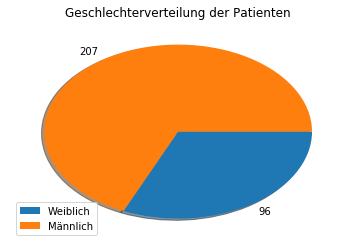

In [5]:
values = [96, 207]
labels = ['Weiblich', 'Männlich']
plt.pie(values, labels= values,counterclock=False, shadow=True)
plt.title('Geschlechterverteilung der Patienten')
plt.legend(labels,loc=3)
plt.show()

**Interpretation**: Der Datensatz enthält 96 weibliche und 207 männliche Patienten. Damit ist der Datensatz hinsichtlich der Geschlechteraufteilung hin zu männlichen Geschlechtern verzerrt, da fast doppelt so viele Daten zu Männern, als zu Frauen vorliegen. 

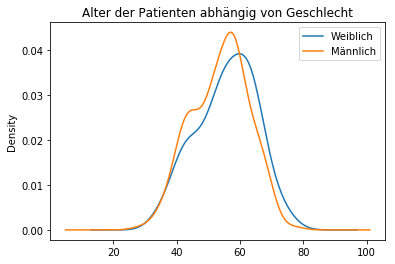

In [6]:
df.groupby('sex').age.plot(kind='kde')
plt.title('Alter der Patienten abhängig von Geschlecht')
labels = ['Weiblich', 'Männlich']
plt.legend(labels,loc=1)

**Interpretation**: Sowohl bei weiblichen, als auch bei männlichen Patienten liegen die meisten daten für Personen zwischen 40 und ca. 75 Jahren vor.

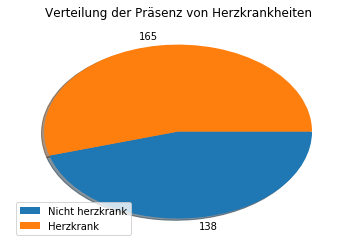

In [7]:
values = [138, 165]
labels = ['Nicht herzkrank', 'Herzkrank']
plt.pie(values, labels= values,counterclock=False, shadow=True)
plt.title('Verteilung der Präsenz von Herzkrankheiten')
plt.legend(labels,loc=3)
plt.show()

**Interpretation**: Hinsichtlich der Präsenz von Herzkrankheiten ist der Datensatz "relativ" ausbalanciert. Somit hat das ML Modell eine augeglichene Informationsbasis für die Klassifizierung von gesunden und kranken Patienten.

Text(0.5,1,'Präsenz von Herzkrankheiten nach Geschlechtern')

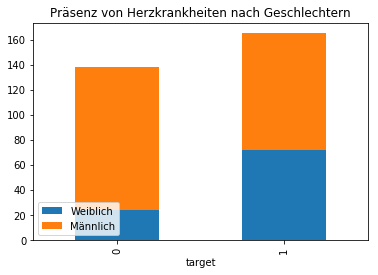

In [8]:
ct_tarsex = pd.crosstab(df.target, df.sex)
ct_tarsex.plot.bar(stacked=True)
labels = ['Weiblich', 'Männlich']
plt.legend(labels,loc=3)
plt.title('Präsenz von Herzkrankheiten nach Geschlechtern')

**Interpretation**: Der Graphik zufolge sind unter den Patienten ohne Herzkrankheiten deutlich mehr Männer als Frauen. Das Modell könnte demnach bei der Klassifizierung von gesunden Patienten daher möglicherweise "biased" bzw. voreingenommen sein und Männer tendenziell öfter als nicht herzkrank einstufen. Jedoch muss bei der Graphik die ungleiche Geschlechterverteilung innerhalb des Datensatzes beachtet werden.

####  1.1.2 Spezifische medizinische Informationen

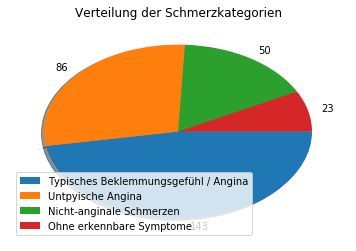

In [9]:
values = [143, 86, 50, 23]
labels = ['Typisches Beklemmungsgefühl / Angina', 'Untpyische Angina', 'Nicht-anginale Schmerzen', 'Ohne erkennbare Symptome']
plt.pie(values, labels= values,counterclock=False, shadow=True)
plt.title('Verteilung der Schmerzkategorien')
plt.legend(labels, loc=3)
plt.show()

**Interpretation**: Fast 50% aller Patienten haben ein typisches Beklemmungsgefühl im Herzbereich, auch Angina genannt. Die verbleibenden Testpersonen teilen sich zu ungefähr gleichen Teilen auf untypische Beklemmungserscheinungen und nicht präsente Symptome auf.

Text(0.5,1,'Schmerzkategorien gemappt zu vorhandenen Herzkrankheiten')

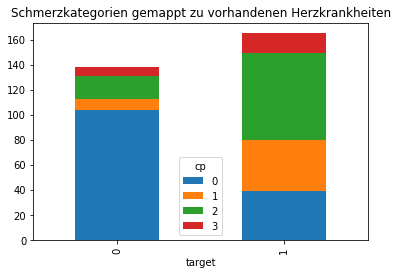

In [10]:
ct2_anglabel = pd.crosstab(df.target, df.cp)
ct2_anglabel.plot.bar(stacked=True)

plt.title('Schmerzkategorien gemappt zu vorhandenen Herzkrankheiten')

**Interpretation**: Entgegen der gängigen Vermutung, dass anginale Schmerzen stark mit Herzkrankheiten korrelieren, sind vor allem nicht-angila und untypische Schmerzen Zeichen für eine Herzkrankheit.

Text(0.5,1,'Anzahl erkannter Gefäße im Verhältnis zu präsenten Herzkrankheiten')

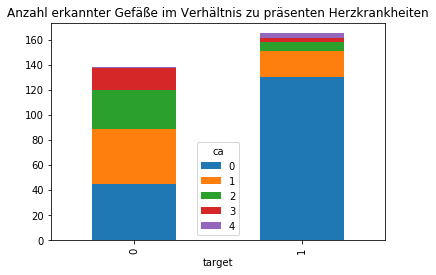

In [11]:
ct2_calabel = pd.crosstab(df.target, df.ca)
ct2_calabel.plot.bar(stacked=True)

plt.title('Anzahl erkannter Gefäße im Verhältnis zu präsenten Herzkrankheiten')

**Interpretation**: Auf Basis des allgemeinen medizinischen Kontexts kann die Hypothese aufgestellt werden, dass Patienten mit 0 erkannten großen Hergefäßen (durch Verstopfung) häufiger unter einer Herzkrankheiten leiden. D.h. je weniger Gefäße erkannt wurden, desto höher wäre die Wahrscheinlichkeit einer Herzkrankheit. 

Die obige Graphik bestätigt diese Vermutung, da ein Großteil aller Patienten mit verstopften Gefäßen tatsächlich unter einer Herzkrankheit leiden. Dies liefert einen ersten Hinweis auf eine vorliegende Korrelation zwischen der Anzahl erkannter Hauptgefäße und dem "Label" Herzkrankheit. 

Text(0.5,1,'Werteverteilung des Ruhepuls')

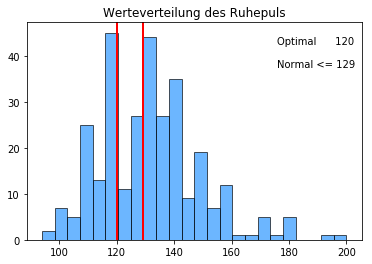

In [12]:
norm_bot = 120
norm_top = 129

result = plt.hist(df[['trestbps']].values, bins=24, color='dodgerblue', edgecolor='k', alpha=0.65)
plt.axvline(norm_bot, color='r', linewidth=2)
plt.axvline(norm_top, color='r', linewidth=2)

_, max_ = plt.ylim()

plt.text(160 + 160/10, 
         max_ - max_/10, 
         'Optimal      {:}'.format(norm_bot))

plt.text(160 + 160/10, 
         max_ - max_/10 - 5, 
         'Normal <= {:}'.format(norm_top))

plt.title('Werteverteilung des Ruhepuls')

**Interpretation**: Der obigen Graphik kann entnommen werden, dass die Mehrheit aller Patienten in ihren Ruhepuls-Werten um Durchschnittswerte zentriert ist. Aus diesem Grund lässt sich vermuten, dass der Ruhepuls als solches nicht direkt mit dem Label korreliert.  

Text(0.5,1,'Werteverteilung der Cholesterin-Konzentration in mg/dl')

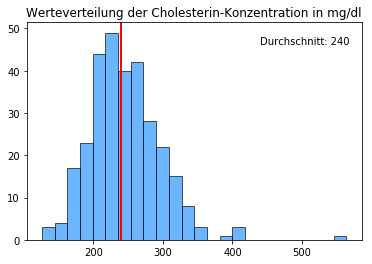

In [13]:
avg = 240

result = plt.hist(df[['chol']].values, bins=24, color='dodgerblue', edgecolor='k', alpha=0.65)
plt.axvline(avg, color='r', linewidth=2)

_, max_ = plt.ylim()

plt.text(400 + 400/10, 
         max_ - max_/10, 
         'Durchschnitt: {:}'.format(avg))

plt.title('Werteverteilung der Cholesterin-Konzentration in mg/dl')

**Interpretation**: In Bezug auf die Cholesterin Konzentration der Patienten lässt sich ein ähnliches Phänomen feststellen. Auch hier wird eine geringe Korrelation mit dem Label vermutet, da sich ein Großteil der Cholesterin Werte des Datensatzes um einen normalen bzw. durchschnittlichen Wertebereich ansiedeln.

Hinweis: Zunächst wurde der Wert von über 500 mg/dl Cholesterin als Outlier betrachtet, weitere Recherchen ergaben, dass ein derartiger Wert allerdings durchaus bei spezifischen Herzkrankheiten auftreten kann.

In [14]:
pandas_profiling.ProfileReport(df)

Number of variables,14
Number of observations,303
Total Missing (%),0.0%
Total size in memory,33.2 KiB
Average record size in memory,112.3 B
Numeric,10
Categorical,0
Boolean,4
Date,0
Text (Unique),0
Rejected,0


#### Interpretation der zusätzlichen Report-Ergebnisse:

- Im Datensatz befindet sich ein Duplikat, welches aus Gründen der Repräsentativität entfernt werden sollte
- Das Attribut "oldpeak" ist in der Verteilung seiner Werte linksverzerrt, da 32,7% aller Datensätze den Wert "0" enthalten. 

Hinweis: Die verbleibenden "zero" Warnungen bei Attributen beziehen sich auf kategrosiche Variablen und sind in diesem Fall nicht negativ auszuwerten.

In [15]:
# Löschen der Duplikate und dauerhafte Speicherung mtihilfe von inplace=True, andernfalls würde eine Kopie erstellt werden
df.drop_duplicates(inplace=True)

## 2. Feature Selection

Um erkennen zu können, welche Attribute tatsächlich ausschlaggebend für die Diagnose einer Herzkrankheit sind, können sowohl ihre Korrelationen mit dem Label "krank" oder "nicht krank", als auch ihre Verbidnung untereinander betrachtet werden. Die Matrix zeigt die jeweiligen Korrelationen auf Basis des Pearson Koeffizients, wobei eine Nähe zu dem Wert 1 eine starke Korrelation bedeutet. 

In [16]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.094962,-0.063107,0.283121,0.207216,0.119492,-0.111590,-0.395235,0.093216,0.206040,-0.164124,0.302261,0.065317,-0.221476
sex,-0.094962,1.000000,-0.051740,-0.057647,-0.195571,0.046022,-0.060351,-0.046439,0.143460,0.098322,-0.032990,0.113060,0.211452,-0.283609
cp,-0.063107,-0.051740,1.000000,0.046486,-0.072682,0.096018,0.041561,0.293367,-0.392937,-0.146692,0.116854,-0.195356,-0.160370,0.432080
trestbps,0.283121,-0.057647,0.046486,1.000000,0.125256,0.178125,-0.115367,-0.048023,0.068526,0.194600,-0.122873,0.099248,0.062870,-0.146269
chol,0.207216,-0.195571,-0.072682,0.125256,1.000000,0.011428,-0.147602,-0.005308,0.064099,0.050086,0.000417,0.086878,0.096810,-0.081437
fbs,0.119492,0.046022,0.096018,0.178125,0.011428,1.000000,-0.083081,-0.007169,0.024729,0.004514,-0.058654,0.144935,-0.032752,-0.026826
restecg,-0.111590,-0.060351,0.041561,-0.115367,-0.147602,-0.083081,1.000000,0.041210,-0.068807,-0.056251,0.090402,-0.083112,-0.010473,0.134874
thalach,-0.395235,-0.046439,0.293367,-0.048023,-0.005308,-0.007169,0.041210,1.000000,-0.377411,-0.342201,0.384754,-0.228311,-0.094910,0.419955
exang,0.093216,0.143460,-0.392937,0.068526,0.064099,0.024729,-0.068807,-0.377411,1.000000,0.286766,-0.256106,0.125377,0.205826,-0.435601
oldpeak,0.206040,0.098322,-0.146692,0.194600,0.050086,0.004514,-0.056251,-0.342201,0.286766,1.000000,-0.576314,0.236560,0.209090,-0.429146


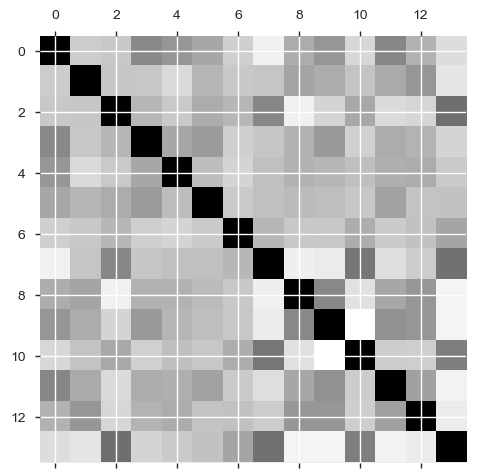

In [17]:
plt.matshow(df.corr())

Vermutete Korrelationen:

- Wie bereits vermutet, haben Ruhepuls und Cholesterin-Konzentration aufgrund ihrer starken Orientierung an Durchschnittswerten keine starke Korrelation zu dem Label. (Korrelation nahe 0)

Am stärksten korrelieren die folgenden Features:

- CP (0,43): Schmerzkategorie von 1-4
- Thalach (0,41): Maximale Herzfrequenz (bei größtmöglicher Anstrengung) in Herzschläge/ Minute
- Exang (-0,43): "Engegefühl" bei sportlicher Aktivität (0 = Nein, 1 = Ja)
- Oldpeak (-0,42): Befund bei EKG (ST Streckensenkung), der eine bestimmte Basislinie nicht unterschreiten sollte
- Ca (-0,40): Anzahl erkennbarer Hauptgefäße

Die Vermutung liegt nahe, dass diese Features am besten für das spätere Model Training geeignet sind. 

Die obige Matrix lässt eine erste Beurteilung der Signifikanz der Attribute zu. Um eine möglichst optimale Anzahl an repräsentativen Attributen bzw. Features zu erhalten, wird eine statistische Selektionsmethode gewählt:

In [18]:
from sklearn.feature_selection import f_classif, SelectKBest

In [19]:
def select_kbest_clf(data_frame, target, k=5):

    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

In [20]:
select_kbest_clf(df, 'target')

,F Score,P Value,Support,Attribute
0,15.474511,1.039484e-04,False,age
1,26.240952,5.402436e-07,False,sex
2,68.864299,3.627384e-15,True,cp
3,6.558676,1.092654e-02,False,trestbps
4,2.002888,1.580370e-01,False,chol
5,0.216045,6.424070e-01,False,fbs
6,5.558449,1.903361e-02,False,restecg
7,64.237793,2.476146e-14,True,thalach
8,70.255191,2.046468e-15,True,exang
9,67.721931,5.814567e-15,True,oldpeak


Die mit "True" gekennzeichneten Attribute sind laut der Analyse als Features am besten geeignet.

## 3. Modeling

#### Pipeline:
- Pipeline 
    - Zusammenfassen von Teilen des Preprocessing und des Classifiers zu einer Pipeline. Da die Pipeline Modifikationen aller Paramter der einzelnen Komponenten anbietet, wird die Anwendung einer Grid Search erleichtert/ermöglicht
    


#### Feature Selection: 
- SelectKBest 
    - Ermitteln der am besten korrelierenden Features -> reduzieren der Features

#### Scaling: 
- StandardScaler
    - Normalizieren der einzelnen Spalten auf einen mean = 0 (Durchschnitt) und eine standard deviation = 1 (Standardabweichung)

#### Parameter Tuning: 
- GridSearchCV 
    - Trainieren mehrerer Modelle mit unterschiedlichen Parameterkombinationen. Hier wird ein Modell pro Kombination trainiert, was diese Methode bei grossen Datensätzen und vielen Parameterkombinationen sehr langsam macht. 
    - Zusätzlich wird Cross Validation angewandt, was den Datensatz in sogenannte Folds einteilt. Die Anzahl kann hier mit Parameter k festgelegt werden. Das Modell wird dann auf verschiedene Kombinationen dieser Folds trainiert und aus den Ergebnissen ein Mittelwert erzeugt. Hierdurch kann Overfitting weitesgehend verhindert werden.
- RandomizedGridSearchCV
    - Randomisierte Grid Search um bei grosser Anzahl an Parameterkombinationen die Trainingszeit zu verringern. Hier werden zufällig Parameterkombinationen gewählt und die entsprechenden Modelle trainiert.
- StratifiedKFold 
    - Methode zur Einteilung des Datensatzes in k Folds


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

In [22]:
#Visualizieren der Confusion Matrix
#Source: https://github.com/rohanjoseph93/Python-for-data-science/blob/master/Grid%20Search%20-%20Breast%20Cancer.ipynb
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=2)

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print('False Negative Rate (should be close to 0): ', cnf_matrix[0][1] / (cnf_matrix[0][1] + cnf_matrix[1][1]))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### 3.1 Data Preprocessing

Aufteilen des Datensatzes in X (Features) und y (Label).
Splitten der X Matrix und des y Vektors in Training- und Testset. Hierzur wird train_test_split von Sklearn verwendet und der Datensatz in 80% Trainings- und 20% Testdaten aufgeteilt.

In [23]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:,:-1],df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print('Training Shapes:', X_train.shape, y_train.shape)
print('Test Shapes:', X_test.shape, y_test.shape)

Training Shapes: (241, 13) (241,)
Test Shapes: (61, 13) (61,)


### 3.2 Dummy Classifier

Der folgende Classifier ist ein initiales Modell, um die Trefferquote eines ML Modells zu zeigen, das bisher mit keinen Methoden optimiert wurde. Es dient zum Vergleich von später eingesetzten Modellen.

In [24]:
from sklearn.linear_model import SGDClassifier

sgdcd = SGDClassifier(random_state = random_state)
sgdcd.fit(X_train,y_train)
ac_sgdcd = sgdcd.score(X_test, y_test)

print('Dummy Classifier Accuracy:', ac_sgdcd)

Dummy Classifier Accuracy: 0.639344262295082


In diesem Fall sind False Negatives (versehentlich als gesund eingestuft) aus medizinischer Perspektive relevanter als False Positives (versehentlich als krank eingestuft), da es wesentlich gravierender ist einen kranken Patienten als gesund einzustufen, als einen gesunden Patienten als krank einzustufen. Wird ein kranker Patient als gesund eingestuft und sucht deshalb keinen Arzt auf, ist dies weitaus schlimmer, als ein gesunder Patient, dessen falsche Diagnose sich spätestens beim nächsten Arztbesuch auflöst. 

Die hierzu passende Metrik ist die False Negative-Rate, welche möglichst niedrig sein sollte (nahe 0). Die Berechnung erfolgt durch die Division der False Negatives durch die Summe aus den False-Negatives und den True-Positives.

Confusion matrix, without normalization
[[29  0]
 [22 10]]
False Negative Rate (should be close to 0):  0.0


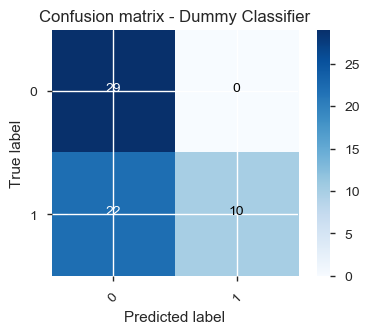

In [25]:
cnf_matrix = confusion_matrix(y_test, sgdcd.predict(X_test))

plt.figure()
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix - Dummy Classifier')
a = plt.gcf()
a.set_size_inches(4,3)
plt.show()

Der \"Dummy Classifier\" hat eine Accuracy von 59%, damit ist er "nur knapp" besser als eine zufällige Klassifizierung, da er über 40% der Labels nicht richtig zuordnet. Da jedoch keine False Positives auftreten, wird eine Specificity von 1 erreicht.

### Vorgehensweise Modeling

Aufbau einer Pipeline:
- Feature Selection ('kbest')
- Scaling ('scaler')
- Classifier

Setzen der Parameter:
- Anzahl der (besten) Features, die verwendet werden sollen
- Classifier spezifische Parameter (n_jobs=-1 erlaubt maximal mögliche Anzahl an parallelen Prozessen)

Fitting / Training der Pipeline:
- Aufrufen der fit() Methode mit den Trainingsdaten

Score der Pipeline mit dem ausgewählten Classifier:
- Aufrufen der score() Methode mit den Testdaten

Hyperparameter Tuning:
- In CLASSIFIERNAME_params werden mögliche Parameter definiert, welche später von der Grid Search kombiniert werden
- Aufrufen der fit() Methode der GridSearchCV mit den Trainingsdaten (trotz integrierter Cross Validation)

Auswerten der Grid Search
- Anzeigen der besten Parameterkombinationen
- Anzeigen der besten erzielten Accuracy durch Abfragen des best_score_ Attributs der Grid Search, welches die Accuracy des besten Models enthält
    - Trainingsdaten, GRIDSEARCH.best_score_
- Verifikation des Ergebnisses durch Aufrufen der score() Methode des besten ermittelten Models 
    - Testdaten, GRIDSEARCH.best_estimator_.score(X_test,y_test)
- Aufrufen der score() Methode des besten Classifiers, welcher durch die Grid Search bestimmt wurde. Hierzu werden die Testdaten verwendet, welche hier jedoch eher als Validation Set verwendet werden

Da die Grid Search eine integrierte Cross Validation durchführt, können die bei Seite gelegten Testdaten als Validationset verwendet werden. Durch die unterschiedlichen Folds wird Overfitting weitesgehend verhindert. Da manche Folds jedoch schlechter performen als andere, ist eine geringere Accuracy als bei der vorherigen Prediction (fit(Trainingsdaten), score(Testdaten), keine Cross Validation) zu erwarten. Die Aussagekraft ist jedoch höher, da es das Generalisieren neuer Daten besser wiederspiegelt.

### 3.3 Linear Classifier

Initialisieren der Pipeline und erster Test des Linear Classifiers mit dem gesplitteten Datensatz:

(Output: Accuracy gemessen am Testdatensatz)

In [26]:
from sklearn.linear_model import SGDClassifier

sgdc_pipe  = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('sgdc', SGDClassifier())
])

sgdc_pipe.set_params(
    kbest__k=5,
    sgdc__eta0=0.1, sgdc__random_state=random_state, sgdc__n_jobs=-1
)

sgdc_pipe.fit(X_train,y_train)

ac_sgdc = sgdc_pipe.score(X_test, y_test)
print('SGD Classifier Accuracy:', ac_sgdc)

SGD Classifier Accuracy: 0.5573770491803278


Parameter Tuning um eine höhere Accuracy zu erzielen:
    
Parameter:
- Modelspezifisch:
    - Regularization/Penalty
    - Learning Rate
- Datenspezifisch
    - Anzahl der (besten) Features

In [27]:
sgdc_params = {
        'sgdc__penalty': ['l1', 'l2', 'none', 'elasticnet'],
        'sgdc__learning_rate': ['constant', 'optimal', 'invscaling'],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

In [28]:
grid_search_sgdc = GridSearchCV(sgdc_pipe, param_grid=sgdc_params, scoring='roc_auc', n_jobs=-1)
grid_search_sgdc.fit(X_train, y_train)

grid_search_sgdc.best_params_

{'kbest__k': 11, 'sgdc__learning_rate': 'constant', 'sgdc__penalty': 'l2'}

In [29]:
grid_search_sgdc.best_score_

0.8980205214645048

In [30]:
ac_sgdc_cv = grid_search_sgdc.best_estimator_.score(X_test,y_test)
print('SGD Classifier Accuracy CV:', ac_sgdc_cv)

SGD Classifier Accuracy CV: 0.8360655737704918


Confusion matrix, without normalization
[[24  5]
 [ 5 27]]
False Negative Rate (should be close to 0):  0.15625


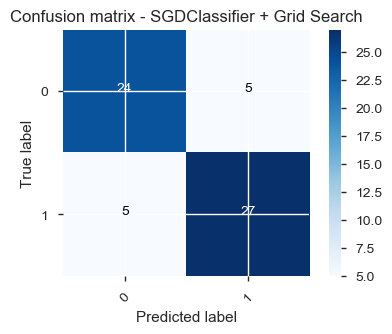

In [31]:
cnf_matrix = confusion_matrix(y_test, grid_search_sgdc.best_estimator_.predict(X_test))

plt.figure()
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix - SGDClassifier + Grid Search')
a = plt.gcf()
a.set_size_inches(4,3)
plt.show()

### 3.4 DecisonTreeClassifier

Initialisieren der Pipeline und erster Test des DecisionTree Classifiers mit dem gesplitteten Datensatz:

(Output: Accuracy gemessen am Testdatensatz)

In [32]:
from sklearn.tree import DecisionTreeClassifier

dtc_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(random_state=random_state))
])

dtc_pipe.set_params(
    kbest__k=5
)

dtc_pipe.fit(X_train, y_train)

ac_dtc = dtc_pipe.score(X_test, y_test)
print('DecisionTree Classifier Accuracy:', ac_dtc)

DecisionTree Classifier Accuracy: 0.819672131147541


Parameter Tuning um eine höhere Accuracy zu erzielen:
    
Parameter:
- Modelspezifisch:
    - Maximale Tiefe des Baumes
    - Maximale Anzahl an Blättern (des Baumes)
- Datenspezifisch
    - Anzahl der (besten) Features

In [33]:
dtc_params = {
        'dtc__max_depth': [2, 3, 5, 10, None],
        'dtc__max_leaf_nodes': [3, 5, 8, 10, 15, 20, None],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

In [34]:
grid_search_dtc = GridSearchCV(dtc_pipe, param_grid=dtc_params, scoring='roc_auc', n_jobs=-1)
grid_search_dtc.fit(X_train, y_train)

grid_search_dtc.best_params_

{'dtc__max_depth': 2, 'dtc__max_leaf_nodes': 8, 'kbest__k': 7}

In [35]:
grid_search_dtc.best_score_

0.8395578245163308

In [36]:
ac_dtc_cv = grid_search_dtc.best_estimator_.score(X_test, y_test)
print('DecisionTree Classifier Accuracy CV:', ac_dtc_cv)

DecisionTree Classifier Accuracy CV: 0.7868852459016393


Confusion matrix, without normalization
[[24  5]
 [ 8 24]]
False Negative Rate (should be close to 0):  0.1724137931034483


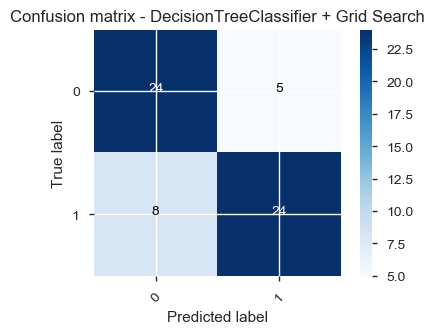

In [37]:
cnf_matrix = confusion_matrix(y_test, grid_search_dtc.best_estimator_.predict(X_test))

plt.figure()
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix - DecisionTreeClassifier + Grid Search')
a = plt.gcf()
a.set_size_inches(4,3)
plt.show()

### 3.5 KNN

Initialisieren der Pipeline und erster Test des K-Nearest-Neighbor Classifiers mit dem gesplitteten Datensatz:

(Output: Accuracy gemessen am Testdatensatz)

In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_pipe.set_params(
    kbest__k=5,
    knn__n_jobs=-1
)

knn_pipe.fit(X_train,y_train)

ac_knn = knn_pipe.score(X_test, y_test)
print('KNN Classifier Accuracy:', ac_knn)

KNN Classifier Accuracy: 0.8852459016393442


Parameter Tuning um eine höhere Accuracy zu erzielen:
    
Parameter:
- Modelspezifisch:
    - Anzahl der einbezogenen Nachbarn
    - Verwendeter Algorithmus
    - Blattgrösse
- Datenspezifisch
    - Anzahl der (besten) Features

In [39]:
knn_params = {
        'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'knn__leaf_size': [20, 30, 40],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

In [40]:
grid_search_knn = GridSearchCV(knn_pipe, param_grid=knn_params, scoring='roc_auc', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

grid_search_knn.best_params_

{'kbest__k': 11,
 'knn__algorithm': 'ball_tree',
 'knn__leaf_size': 20,
 'knn__n_neighbors': 15}

In [41]:
grid_search_knn.best_score_

0.8935406549514432

In [42]:
ac_knn_cv = grid_search_knn.best_estimator_.score(X_test,y_test)
print('KNN Classifier Accuracy CV:', ac_knn_cv)

KNN Classifier Accuracy CV: 0.9180327868852459


Confusion matrix, without normalization
[[27  2]
 [ 3 29]]
False Negative Rate (should be close to 0):  0.06451612903225806


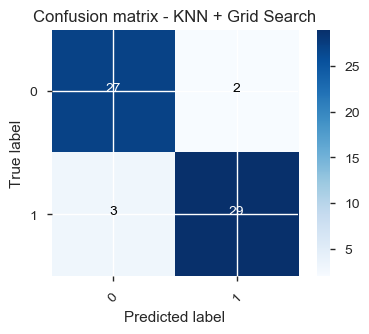

In [43]:
cnf_matrix = confusion_matrix(y_test, grid_search_knn.best_estimator_.predict(X_test))

plt.figure()
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix - KNN + Grid Search')
a = plt.gcf()
a.set_size_inches(4,3)
plt.show()

### 3.6 RandomForestClassifier

Initialisieren der Pipeline und erster Test des RandomForest Classifiers mit dem gesplitteten Datensatz:

(Output: Accuracy gemessen am Testdatensatz)

In [44]:
from sklearn.ensemble import RandomForestClassifier

rfc_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

rfc_pipe.set_params(
    rfc__random_state=random_state,
    kbest__k=5
)

rfc_pipe.fit(X_train, y_train)

ac_rfc = rfc_pipe.score(X_test, y_test)
print('RandomForest Classifier Accuracy:', ac_rfc)

RandomForest Classifier Accuracy: 0.7868852459016393


C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Parameter Tuning um eine höhere Accuracy zu erzielen:
    
Parameter:
- Modelspezifisch:
    - Minimale Anzahl an Sampels, bevor ein Ast aufgespaltet werden darf
    - Maximale Tiefe des Baumes
    - Anzahl der zu trainierenden Estimators
    - Einsatz von Bootstrap-Samples
    - Minimale Samples pro Blatt
- Datenspezifisch
    - Anzahl der (besten) Features

In [45]:
rfc_params = {
        'rfc__min_samples_split': [2, 5, 10, 15, 20],
        'rfc__max_depth': [5, 10, 15, 20, 25, None],
        'rfc__n_estimators': [100, 250, 500, 750, 1000],
        'rfc__bootstrap': [True, False],
        'rfc__min_samples_leaf': [1, 2, 5, 6, 10],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

params_comb_all = int(5 * 6 * 5 * 2 * 5  * 6)
param_comb = int(params_comb_all / 100)

print('GridSearchCV parameter combinations: ' + str(params_comb_all) + '\n' + 'RandomizedSearchCV parameter combinations: ' + str(param_comb))

GridSearchCV parameter combinations: 9000
RandomizedSearchCV parameter combinations: 90


In [46]:
rnd_search_rfc = RandomizedSearchCV(rfc_pipe, param_distributions=rfc_params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, random_state=random_state )
rnd_search_rfc.fit(X_train, y_train)

rnd_search_rfc.best_params_

{'rfc__n_estimators': 1000,
 'rfc__min_samples_split': 20,
 'rfc__min_samples_leaf': 6,
 'rfc__max_depth': 15,
 'rfc__bootstrap': True,
 'kbest__k': 13}

In [47]:
rnd_search_rfc.best_score_

0.9057877190657274

In [48]:
ac_rfc_cv = rnd_search_rfc.best_estimator_.score(X_test,y_test)
print('RandomForest Classifier Accuracy CV:', ac_rfc_cv)

RandomForest Classifier Accuracy CV: 0.8688524590163934


Confusion matrix, without normalization
[[24  5]
 [ 3 29]]
False Negative Rate (should be close to 0):  0.14705882352941177


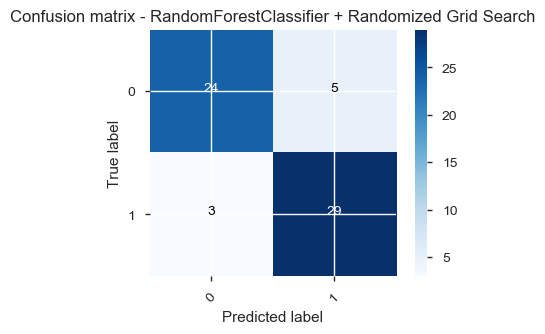

In [49]:
cnf_matrix = confusion_matrix(y_test, rnd_search_rfc.best_estimator_.predict(X_test))

plt.figure()
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix - RandomForestClassifier + Randomized Grid Search')
a = plt.gcf()
a.set_size_inches(4,3)
plt.show()

## Fazit

Im Zuge der Analyse von Patientendaten für die Vorhersage von Herzkrankheiten wurden verschiedene gängige ML Praktiken durchgeführt, wie beispielweise Data Preprocessing, Feature Engineering und Modeling. Um bestmögliche Vorhersagen zu erreichen, wurden verschiedene Classifier Modelle mit den Daten trainiert. Im Folgenden werden die Modelle in ihrer Performance gegenübergestellt und die Grösse des Datensatyes kritisch evaluiert. 

### Vergleich der Modelle

Durch das Trainieren verschiedener Modelle und Optimierung der zugehörigen Stellschrauben (Hyperparameter), konnten mehrere Lösungsansätze evaluiert werden.

In [50]:
ac_df = pd.DataFrame()
ac_df['Dummy'] = [ac_sgdcd, '-']
ac_df['Linear'] = [ac_sgdc, ac_sgdc_cv]
ac_df['Decision Tree'] = [ac_dtc, ac_dtc_cv]
ac_df['KNN'] = [ac_knn, ac_knn_cv]
ac_df['Random Forest'] = [ac_rfc, ac_rfc_cv]
ac_df

#0 ist ohne CV, 1 ist mit CV

,Dummy,Linear,Decision Tree,KNN,Random Forest
0,0.639344,0.557377,0.819672,0.885246,0.786885
1,-,0.836066,0.786885,0.918033,0.868852


Der obige Vergleich anhand der Accuracy zeigt, dass das KNN Modell in Verbidnung mit Cross Validation die besten Ergebnisse erzielt. Unter Verwendung dieses Modells kann eine vorhandene Herzkrankheit mit einer Accuracy von 0.9 vorhergesagt werden. Dies bedeutet, dass auf Basis der eingegebenen Daten eine Herzkrankheit zu 90% korrekt diagnostiziert werden kann.

### Kritische Betrachtung

Sowohl die Auswahl der Parameter, als auch die obige Evaluation der Modelle wurde hauptsächlich anhand der Performance Metrik "Accuracy" durchgeführt. Die Akkuratheit stellt eine repräsentative Kennzahl dar, wenn eine möglichst gleihe Verteilung der Labels vorliegt. Auch wenn diese Bedingung durch den Datensatz gut erfüllt ist, sollten bei einer tiefergrehenden Beurteilung auch andere Metriken, wie beispielsweise die erwähnte "True Negative Rate" in Betracht gezogen werden.

#### Kleiner Datensatz

Im Vergleich zu gängigen Machine Learning Projekten handelt sich bei dem verwendeten Datensatz mit ca. 300 Einträgen um einen sehr kleinen Datensatz, dessen Nutzung einige Risiken birgt. Die Accuracy von über 90% sollte daher unter den Risiken einer geringeren Repräsentativität und der Beeinträchtigung der Fähigkeit der Generalisierung des Modells betrachtet werden. Der Datensatz repräsentiert nur einen kleinen Teil der realen Welt und spiegelt damit nur wenige Krankheitsmuster wider. Es besteht damit die Gefahr des Overifittings, das bedeutet, dass das Modell möglicherweise zu stark an die gegebenen Daten angepasst ist und bei neuen, ungesehenen Daten schlechtere Vorhersagen trifft.

## Zusatz Modeling

Im Folgenden wird versucht mit Hilfe des XGBoost Algorithmus und eines Deep Neural Networks eine möglichst hohe Accuracy zu erziehlen. Es bleibt jedoch zu erwähnen, dass dies aufgrund des sehr kleinen Datensatzes (~ 300 Tupeln) mit Vorsicht zu behandeln ist und am besten als "Mit Kanonen auf Spatzen schiessen" beschrieben werden kann.

### Modeling - xgboost

In [51]:
from xgboost import XGBClassifier

xgc_pipe = Pipeline([
    ('kbest', SelectKBest(f_classif)),
    ('scaler', StandardScaler()),
    ('xgc', XGBClassifier())
])

xgc_pipe.set_params(
    kbest__k=5
)

xgc_pipe.fit(X_train, y_train)

xgc_pipe.score(X_test, y_test)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8360655737704918

Da hier 480 Parameterkombinationen existieren, wird vorerst eine RandomizedSearchCV durchgefürht, welche die Kombinationen auf 96 reduziert und somit auch auf einem Mittelklasserechner in annehmbarer Zeit durchgeführt werden kann.

Parameter Tuning um eine höhere Accuracy zu erzielen:
    
Parameter:
- Modelspezifisch:
    - Learning Rate
    - Maximale Tiefe der einzelnen Baume
    - Anzahl der Estimator die trainiert bzw. für die Prediciton zu Rate gezogen werden
- Datenspezifisch
    - Anzahl der (besten) Features

In [52]:
xgc_params = {
        'xgc__learning_rate': [.0001, .001, .01, .1],
        'xgc__max_depth': [5, 10, 15, 20, 25],
        'xgc__n_estimators': [250, 500, 750, 1000],
    
        'kbest__k': [3, 5, 7, 9, 11, 13]
        }

params_comb_all = int(4 * 5 * 4 * 6)
param_comb = int(params_comb_all / 5)

print('GridSearchCV parameter combinations: ' + str(params_comb_all) + '\n' + 'RandomizedSearchCV parameter combinations: ' + str(param_comb))

GridSearchCV parameter combinations: 480
RandomizedSearchCV parameter combinations: 96


In [53]:
rnd_search_xgc = RandomizedSearchCV(xgc_pipe, param_distributions=xgc_params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, random_state=random_state )
rnd_search_xgc.fit(X_train, y_train)

rnd_search_xgc.best_params_

{'xgc__n_estimators': 750,
 'xgc__max_depth': 10,
 'xgc__learning_rate': 0.001,
 'kbest__k': 9}

In [54]:
rnd_search_xgc.best_score_

0.8778622549369437

In [55]:
rnd_search_xgc.best_estimator_.score(X_test,y_test)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.819672131147541

In [56]:
y_pred = rnd_search_xgc.best_estimator_.predict(X_test)
confusion_matrix(y_test, y_pred)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[27,  2],
       [ 9, 23]], dtype=int64)

Um das Model noch weiter zu verbessern wird die in diesem Falle etwas aufwendigere GridSearchCV durchgeführt, welche alle 480 Parameterkombinationen abdeckt.

In [57]:
grid_search_xgc = GridSearchCV(xgc_pipe, param_grid=xgc_params, scoring='roc_auc', n_jobs=-1)
grid_search_xgc.fit(X_train, y_train)

grid_search_xgc.best_params_

{'kbest__k': 13,
 'xgc__learning_rate': 0.01,
 'xgc__max_depth': 5,
 'xgc__n_estimators': 500}

In [58]:
grid_search_xgc.best_score_

0.8801763853631072

In [59]:
grid_search_xgc.best_estimator_.score(X_test,y_test)

C:\Users\Marius\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8524590163934426

### Modeling - Neural Network with Keras

Base Setup:

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

Number of Neurons in Hidden Layer:

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.




#### Model Aufbau:
- Input Layer mit 13 Inputs 
    - alle verfügbaren Features werden verwendet
- Hidden Layer mit 10 Neuronen
    - relu als Activation Function
- Output Layer mit 1 Ouput
    - Binary Classification, sigmoid als Activation Function -> Value entweder 0 oder 1
    
#### Model Parameter:
- Loss Function
    - Binary Crossentropy
- Optimizer
    - Adam
- Zu optimierende Metrik
    - Accuracy
- Dense Layer
    - Neuron eines Layers erhält Input von allen Neuronen des vorangeheneden Layers
- Sequential
    - Feed Forward
    
#### Zusatz:
Auch hier wird wieder eine Pipeline verwendet um das Scaling direkt in den Prozess zu integrieren. Durch den Keras Wrapper, welcher von Sklearn bereitgestellt wird, lässt sich der KerasClassifier wie ein Sklearn nativer Classifier verwenden (Stellt z.B. Methoden wie fit() und score() bereit.

Zudem wird Cross Validation eingesetzt, wobei der Datensatz in k = 10 Folds aufgeteilt und anschliessend kombiniert wird. Auf ein Test- bzw. Validationset wird hier verzichtet, da ein DNN einen grösseren Datensatz benötigt und durch die Cross Validation hier aussreichend Schutz gegen Overfitting existiert. Tradeoff hier zwischen Overfitting und Datensatzgrösse!

In [61]:
def keras_model():
    model = Sequential()
    model.add(Dense(22, input_dim=5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [62]:
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)

In [63]:
estimators = []
estimators.append(('scaler', StandardScaler()))
estimators.append(('keras_clf', KerasClassifier(build_fn=keras_model, epochs=200, batch_size=5, verbose=0)))

pipeline = Pipeline(estimators)

Accuracy mit Cross Validation (gemittelt):

In [64]:
results = cross_val_score(pipeline, X[['cp', 'thalach', 'exang', 'oldpeak', 'ca']], y, cv=kfold)
print("Accuracy der verschiedenen Folds: ", results)
print("Accuracy: mean %.2f%% (std %.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Accuracy der verschiedenen Folds:  [0.84 0.9  0.7  0.9  0.8  0.87 0.7  0.8  0.87 0.83]
Accuracy: mean 82.09% (std 6.91%)


Im Verlgeich die Accuracy ohne Cross Validation (ein einzelner Split):

In [65]:
pipeline.fit(X_train[['cp', 'thalach', 'exang', 'oldpeak', 'ca']], y_train)

y_pred = pipeline.predict(X_test[['cp', 'thalach', 'exang', 'oldpeak', 'ca']])

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8688524590163934

13 features = all
5 features = cp thalach exang oldpeak ca

#### Neural Network Configurations
I played around with the number of neurons in the hidden layer, but finally sticked to a formula that worked quite well.

Input, Hidden, Output, Accuracy
13 - 10 - 1 	80.75

5 - 10 - 1 		83.06

5 - 4 - 1 		81.43

5 - 15 - 1		83.42

5 - 22 - 1 		83.75

5 - 30 - 1      81.75 


5 - 22 - 5 - 1		82.40

5 - 15 - 5 -  1		81.09

	